<a href="https://colab.research.google.com/github/adnaneaabbar/stock-trading-system/blob/master/stock_trading_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nous allons tout d'abord faire l'étude, sur la banque d'investissement GS - Goldman Sachs Inc. Nous allons essayer de prédire à l'aide de séries chronologiques les prix de leurs actions.

---

# Etude à base de modèle LSTM


---

## Etape 1 : Chargement et analyse des données.

Nous utiliserons les données historiques des 10 dernières années du cours des actions de GS. Vous pouvez trouver les données sur yahoo finance.


In [0]:
import numpy as np
import pandas as pd 

In [0]:
url = 'https://raw.githubusercontent.com/adnaneaabbar/stock-trading-system/master/data/goldman_sachs.csv?token=AKSKTRUAR2AK2UA6KZLPFDC6Z5GH4'
gs = pd.read_csv(url)

In [4]:
gs.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,167.289993,170.130005,166.929993,168.839996,146.078110,6401800
1,2010-01-04,170.050003,174.250000,169.509995,173.080002,149.746597,9135000
2,2010-01-05,173.000000,176.259995,172.570007,176.139999,152.394012,11659400
3,2010-01-06,175.380005,175.380005,173.759995,174.259995,150.767426,7381100
4,2010-01-07,174.320007,178.750000,173.949997,177.669998,153.717728,8727400


In [5]:
gs.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2260,2018-12-24,159.000000,160.000000,154.309998,156.350006,152.260864,3783500
2261,2018-12-26,157.000000,163.110001,151.699997,162.929993,158.668777,7054700
2262,2018-12-27,160.119995,165.410004,159.020004,165.410004,161.083923,4973000
2263,2018-12-28,165.639999,165.949997,162.020004,163.029999,158.766159,4110500
2264,2018-12-31,163.779999,167.119995,163.779999,167.050003,162.681030,4550000



Comme vous pouvez le voir, il y a 2265 lignes, chacune représentant les attributs boursiers d'une journée pour la banque. Traçons les différents attributs :

<Figure size 432x288 with 0 Axes>

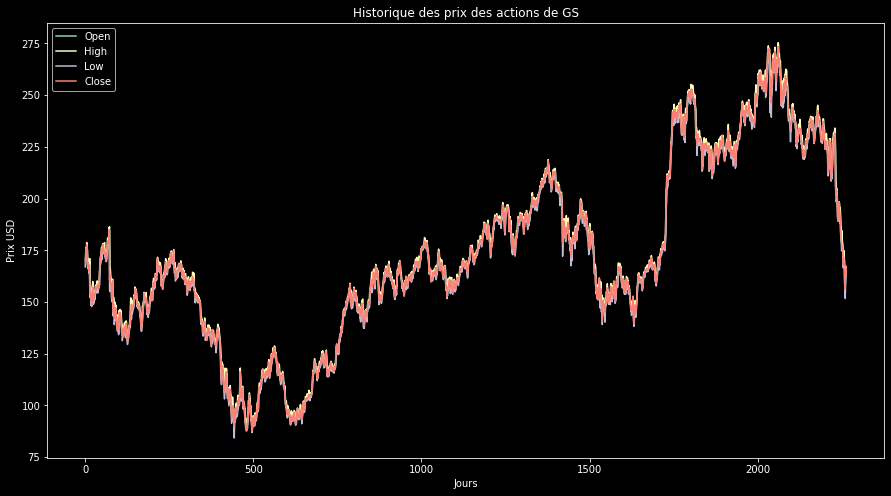

In [6]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use('dark_background')

plt.figure()
plt.figure(figsize=(15,8))
plt.plot(gs["Open"])
plt.plot(gs["High"])
plt.plot(gs["Low"])
plt.plot(gs["Close"])
plt.title('Historique des prix des actions de GS')
plt.ylabel('Prix USD')
plt.xlabel('Jours')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()


Les prix - Open, Close, Low, High - ne varient pas trop les uns des autres, sauf occasionnellement. Traçons le Volume:

<Figure size 432x288 with 0 Axes>

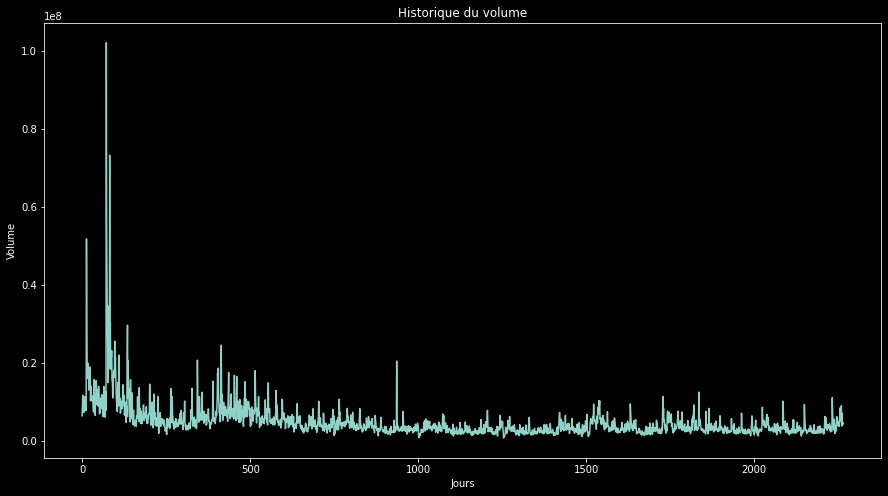

In [7]:
plt.figure()
plt.figure(figsize=(15,8))
plt.plot(gs["Volume"])
plt.title('Historique du volume')
plt.ylabel('Volume')
plt.xlabel('Jours')
plt.show()

Il y a une forte augmentation du nombre de transactions autour du 80ème jour sur la chronologie, qui coïncide avec la chute soudaine du cours des actions just après quelques jours.


Après avoir chargé les données, nous nous assurons que toutes les données sont présentes, lorsqu'une donnée n'existe pas, elle est remplacée par la valeur null ou NaN.

In [8]:
gs.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Comme nous pouvons voir toutes les valeurs existent et de type int64.

## Etape 2 : Normalisation des données.

Les données ne sont pas normalisées et la plage pour chaque colonne varie, en particulier le volume. La normalisation des données aide l'algorithme à converger, c'est-à-dire à trouver efficacement le minimum local / global. 


Nous utiliserons MinMaxScaler de Sci-kit Learn. Mais avant cela, nous devons diviser l'ensemble de données en ensembles de données d'apprentissage(**training**) et de **test**. Je vais également convertir le *DataFrame* en *ndarray* dans le processus.


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# definir les colonnes qu'on va nourrir à notre modèle d'apprentissage
train_cols = ["Open","High","Low","Close","Volume"]

# nous voulons 80% des données en training et les 20% qui restent pour tester le modèle sur des données qu'il n'a pas encore appris
gs_train, gs_test = train_test_split(gs, train_size=0.8, test_size=0.2, shuffle=False)

# regarder la forme de nos données, leur taille..
print(gs_train.shape)
print(gs_test.shape)

# redimensionnement pour garder les colonnes qui nous interéssent
x = gs_train.loc[:,train_cols].values
xx = gs_test.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(xx)

print(x_train.shape)
print(x_test.shape)

(1812, 7)
(453, 7)
(1812, 5)
(453, 5)


## Etape 3 : Conversion des données en séries chronologiques.


Les ***LSTM***s consomment des entrées au format **[batch_size, time_steps, features]** un tableau tridimensionnel.


*   ***batch_size*** : indique le nombre d'échantillons d'entrée que vous souhaitez que votre réseau processe avant de mettre à jour les poids. L'utilisation d'une très petite taille de lot réduit la vitesse de formation et d'autre part, l'utilisation d'une taille de lot trop grande réduit la capacité des modèles à se généraliser à différentes données et consomme également plus de mémoire.



In [0]:
batch_size = 20

*   ***time_steps*** : définissent le nombre d'unités dans le temps passé que vous souhaitez que votre réseau prenne en considération. Dans notre cas, nous utiliserons la valeur **60**, c'est-à-dire que nous examinerons **2 mois** de données pour prédire le prix du jour suivant.



In [0]:
time_steps = 60



*   ***features*** : indique le nombre d'attributs utilisés pour représenter chaque ***time_step***.


Nous allons écrire deux fonctions qui vont nous permettre de faire cette conversion de nos données en séries chronologiques.

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook

def build_timeseries(matrix, y_col_index):
    # y_col_index est l'indice dela colonne qui sera l'output
    '''
     le dernier échantillon permet de prédire la dernière case
     donc le nombre total d'échantillons est len(matrix) - time_steps
    '''
    n = matrix.shape[0] - time_steps
    m = matrix.shape[1]

    x = np.zeros((n, time_steps, m))
    y = np.zeros((n,))
    
    for i in tqdm_notebook(range(n)):
        x[i] = matrix[i:time_steps+i]
        y[i] = matrix[time_steps+i, y_col_index]
    print("La taille de la série chronologique est :\nInput : ", x.shape, "\nOutput : ", y.shape)
    return x, y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.



***y_col_index*** est l'indice de la colonne output. Supposons maintenant qu'après la conversion des données vous avez **41 échantillons** dans votre jeu de données d'entraînement mais votre ***batch_size*** est de **20** nous aurons un échantillon qui ne sera pas utilisé.

Pour raison de nettoyage de données, nous devrons couper l'ensemble d'apprentissage pour supprimer les échantillons laissés de côté.

In [0]:
# coupe l'ensemble d'apprentissage en une taille divisible par le batch_size
def trim_dataset(matrix, batch_size):
    rows_to_drop = matrix.shape[0] % batch_size
    if(rows_to_drop > 0):
        return matrix[:-rows_to_drop] # retire rows_to_drop ligne depuis la fin
    else:
        return matrix

### Maintenant on peut faire la conversion de notre dataset.

In [14]:
# training set
x_t, y_t = build_timeseries(x_train, 3) # y_col_index=3 car on prédit la colonne prix 'Close'
x_t = trim_dataset(x_t, batch_size)
y_t = trim_dataset(y_t, batch_size)

# validation set and test set
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size), 2)


La taille de la série chronologique est :
Input :  (1752, 60, 5) 
Output :  (1752,)



La taille de la série chronologique est :
Input :  (393, 60, 5) 
Output :  (393,)


## Etape 4 : Création du modèle.


Le LSTM est une variation des réseaux de neurones récurrents, nous allons utiliser **une couche de 100 blocks LSTM**, **un dropout de 0.5** qui va permettre de désactiver la moitié des neurones aléatoirement pour accélérer l'apprentissage, **une couche** qui applique la fonction ***relu*** qui est tout simplement la fonction x -> max(x, 0) effectuée élément par élément, et enfin **une couche** qui applique la fonction ***sigmoid*** .

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/13a5596ec9730facb11304344463632904f83242)

Nous allons laisser le modèle s'entraîner à minimiser la fonction de coût qui est l'**erreur en moyenne quadratique MSE** à l'aide de l'algorithme d'optimistion RMSprop, nous allons fixer le pas d'apprentissage à 0.0001 en avançant vers le minimum de cette fonction de coût, nous pourrions le changer si nous voulons et voir ce qui se passerait.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers

learning_rate = 1e-4
optimizer = optimizers.RMSprop(lr=learning_rate)

In [25]:
model = Sequential([
    LSTM(100, batch_input_shape=(batch_size, time_steps, x_t.shape[2]), stateful=True, kernel_initializer='random_uniform'),
    Dropout(0.5),
    Dense(20,activation='relu'),
    Dense(1,activation='sigmoid')                  
])

model.summary()

model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (20, 100)                 42400     
_________________________________________________________________
dropout_2 (Dropout)          (20, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (20, 20)                  2020      
_________________________________________________________________
dense_4 (Dense)              (20, 1)                   21        
Total params: 44,441
Trainable params: 44,441
Non-trainable params: 0
_________________________________________________________________


## Il ne reste plus qu'à lancer l'apprentissage.